In [1]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

DATA_DIR = Path("data/benchmarking")

In [2]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [3]:
def get_n_sidewalk_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash_sidewalk"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [4]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_sidewalk_crashes": get_n_sidewalk_crashes(steps_df),
    }

    return steps_data

In [5]:
def get_scenarios_df(dir: Path):
    paths = list(dir.glob("*/*.json"))

    scenarios = []
    for file_path in tqdm(paths):

        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        dir = file_path.__str__().split("/")[-2]
        _, dr, _, dt = dir.split("_")
        scenario_data["decision_repeat"] = int(dr)
        scenario_data["dt"] = float(dt)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))
        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)

In [6]:
df = get_scenarios_df(DATA_DIR)

100%|██████████| 648/648 [00:02<00:00, 239.36it/s]


In [7]:
df = df.set_index(
    [
        "dt",
        "decision_repeat",
        "seed",
    ],
    verify_integrity=True,
)

df = df.sort_index()

In [8]:
df["n_crashed_vehicles"].describe()
df["n_sidewalk_crashes"].describe()

count    648.000000
mean       0.637346
std        1.285862
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        7.000000
Name: n_sidewalk_crashes, dtype: float64

In [9]:
# calculate driving score
# ! Problem changing the values here in the analysis can change % error

df["driving_score"] = (
    df["route_completion"]
    * df["in_road_percentage"]
    * (0.65) ** df["n_sidewalk_crashes"]
    * (0.60) ** df["n_crashed_vehicles"]
)

In [10]:
# oracle if the one of default parameters
oracle_ds = df.xs((0.02, 5))["driving_score"]
pd.set_option("display.float_format", lambda x: "%.3f" % x)
oracle_ds.describe()

count   54.000
mean     0.704
std      0.293
min      0.125
25%      0.466
50%      0.596
75%      0.991
max      0.995
Name: driving_score, dtype: float64

In [11]:
df["driving_score_error"] = (df["driving_score"] - oracle_ds).abs()
# df

In [12]:
palette = sns.color_palette("hls", 3)
x_ticks = df.index.get_level_values("decision_repeat").unique().to_list()
x_ticks

[5, 10, 15, 20]

## Original plotting


In [13]:
agg = df.select_dtypes("number").groupby(by=["dt", "decision_repeat"]).mean()
agg

start_ts  initialized_ts  scenario_done_ts  init_time  \
dt    decision_repeat                                                          
0.020 5               14181.035       14181.262         14215.644      0.228   
      10              14254.799       14255.025         14271.979      0.227   
      15              14295.907       14296.131         14309.678      0.224   
      20              14327.830       14328.056         14338.692      0.226   
0.030 5               14216.030       14216.260         14237.611      0.230   
      10              14272.344       14272.570         14284.591      0.225   
      15              14310.040       14310.264         14319.620      0.224   
      20              14339.054       14339.281         14347.110      0.227   
0.040 5               14237.977       14238.202         14254.432      0.225   
      10              14284.952       14285.175         14295.545      0.223   
      15              14319.979       14320.203         14327.471      0.224   
      20              14347.472       14347.697         14352.658      0.226   

                       scenario_time  total_time  n_crashed_vehicles  \
dt    decision_repeat                                                  
0.020 5                       34.382      34.610               0.741   
      10                      16.954      17.181               0.741   
      15                      13.547      13.771               0.907   
      20                      10.636      10.862               0.870   
0.030 5                       21.351      21.581               0.759   
      10                      12.021      12.247               0.907   
      15                       9.356       9.580               1.056   
      20                       7.829       8.055               1.204   
0.040 5                       16.231      16.456               0.852   
      10                      10.370      10.593               1.259   
      15                       7.268       7.492               1.333   
      20                       4.961       5.187               1.056   

                       max_steps  route_completion  in_road_percentage  \
dt    decision_repeat                                                    
0.020 5                 2740.796             0.946               1.000   
      10                1370.407             0.955               1.000   
      15                 913.556             0.947               1.000   
      20                 685.204             0.975               1.000   
0.030 5                 1827.185             0.969               1.000   
      10                 913.556             0.967               1.000   
      15                 609.074             0.927               0.999   
      20                 456.796             0.854               0.997   
0.040 5                 1370.407             0.954               1.000   
      10                 685.204             0.955               1.000   
      15                 456.796             0.904               0.997   
      20                 342.667             0.691               0.991   

                       n_sidewalk_crashes  driving_score  driving_score_error  
dt    decision_repeat                                                          
0.020 5                             0.037          0.704                0.000  
      10                            0.056          0.696                0.177  
      15                            0.278          0.625                0.201  
      20                            0.611          0.601                0.270  
0.030 5                             0.185          0.697                0.151  
      10                            0.315          0.634                0.240  
      15                            0.741          0.488                0.344  
      20                            1.093          0.356                0.417  
0.040 5                             0.333          0.623

### RQ1


Text(0.5, 0, 'Decision repeat')

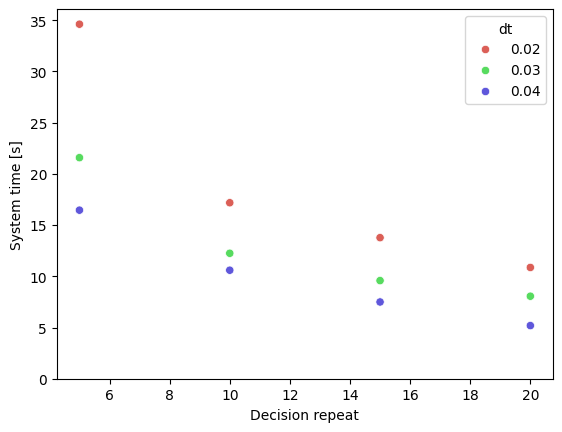

In [14]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="total_time", hue="dt", palette=palette
)
ax.set_ylim(0)
ax.set_ylabel("System time [s]")
ax.set_xlabel("Decision repeat")
# ax.set_xticks(x_ticks)

### RQ2


Text(0, 0.5, 'Driving Score Error')

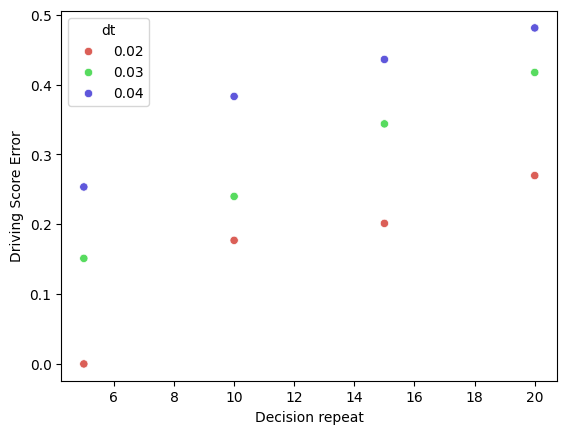

In [15]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="driving_score_error", hue="dt", palette=palette
)

ax.set_xlabel("Decision repeat")


ax.set_ylabel("Driving Score Error")